In [ ]:
#Loading required library
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 


In [ ]:

# read in our data and preprocess it
df = pd.read_csv('https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv')
df = df.dropna() #exclude any rows with missing data


In [ ]:
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


In [ ]:

# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

# **Naive Bayes classifier**



In [ ]:
#pre-processing the data 
from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer and feature extraction
vectorizer = CountVectorizer(analyzer = "word", 
                             binary = True, 
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names())

In [ ]:
# create training and test data
from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=0.2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
# evaluate Naive Bayes classifier
train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 94.53%
Testing Accuracy: 90.69%


#**Convolutional DNN**


In [ ]:
# vectorize the text samples into a 2D integer tensor 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#pre-processing data 
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(25000, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=5000, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [ ]:
# split the data  
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=0.2)

In [ ]:
# build a 1D convnet with global maxpooling                                                                      

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         300, 
                         input_length=5000,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 300)         7500300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 128)         192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 7,709,069
Trainable params: 7,709,069
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the model

history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 475s 12s/step - loss: 0.4060 - accuracy: 0.8471 - val_loss: 0.2071 - val_accuracy: 0.9298
Epoch 2/10
40/40 [==============================] - 479s 12s/step - loss: 0.1115 - accuracy: 0.9667 - val_loss: 0.1206 - val_accuracy: 0.9519
Epoch 3/10
40/40 [==============================] - 472s 12s/step - loss: 0.0257 - accuracy: 0.9966 - val_loss: 0.1067 - val_accuracy: 0.9605
Epoch 4/10
40/40 [==============================] - 473s 12s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0973 - val_accuracy: 0.9621
Epoch 5/10
40/40 [==============================] - 471s 12s/step - loss: 7.4275e-04 - accuracy: 1.0000 - val_loss: 0.1113 - val_accuracy: 0.9605
Epoch 6/10
40/40 [==============================] - 470s 12s/step - loss: 8.2490e-05 - accuracy: 1.0000 - val_loss: 0.1198 - val_accuracy: 0.9621
Epoch 7/10
40/40 [==============================] - 469s 12s/step - loss: 9.5844e-06 - accuracy: 1.0000 - val_loss: 0.1380 - val_accuracy: 0

In [ ]:
# evaluate model

def predict(X):
    return np.rint(model.predict(X)) # threshold the predictions to retrieve labels

train_acc, test_acc = evaluate_model(predict,
                                     x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 100.00%
Testing Accuracy: 95.97%


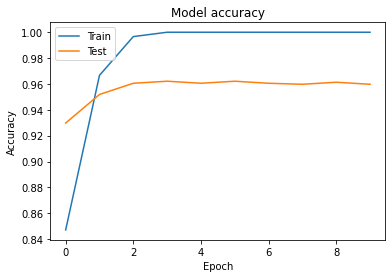

In [ ]:

# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#**Passive Aggressive Classifier**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# split the data 

x_train,x_test,y_train,y_test=train_test_split(df['text'], labels, test_size=0.2, random_state=7)

In [ ]:
#Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

#Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

In [ ]:
#Initialize a PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
#Predict on the test set and calculate accuracy
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 92.66%




# **RNN**

In [ ]:
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')


Correct version of Tensorflow installed.


In [ ]:
df['class'] = np.where(df['label']== 'FAKE', 0, 1) # adding a class column (fake = 0, real = 1)


In [ ]:
df.head()

,id,title,text,label,class
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['class'], test_size=0.20, random_state=18)

In [ ]:
# pre-processing data
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

x_train = normalize(x_train)
x_test = normalize(x_test)

In [ ]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

In [ ]:
# tokenize the text into vectors 
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=256)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
________________________________________________

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])



In [ ]:
history = model.fit(x_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
153/153 [==============================] - 65s 422ms/step - loss: 0.6897 - accuracy: 0.5019 - val_loss: 0.6842 - val_accuracy: 0.5030
Epoch 2/10
153/153 [==============================] - 64s 417ms/step - loss: 0.6404 - accuracy: 0.5576 - val_loss: 0.6172 - val_accuracy: 0.6864
Epoch 3/10
153/153 [==============================] - 63s 414ms/step - loss: 0.4672 - accuracy: 0.8132 - val_loss: 0.4685 - val_accuracy: 0.7909
Epoch 4/10
153/153 [==============================] - 63s 412ms/step - loss: 0.3627 - accuracy: 0.8652 - val_loss: 0.3956 - val_accuracy: 0.8304
Epoch 5/10
153/153 [==============================] - 63s 414ms/step - loss: 0.2897 - accuracy: 0.8954 - val_loss: 0.3695 - val_accuracy: 0.8501
Epoch 6/10
153/153 [==============================] - 63s 409ms/step - loss: 0.2490 - accuracy: 0.9147 - val_loss: 0.4173 - val_accuracy: 0.8481
Epoch 7/10
153/153 [==============================] - 63s 413ms/step - loss: 0.2073 - accuracy: 0.9309 - val_loss: 0.3550 - val_ac

In [ ]:
model.evaluate(x_test, y_test)

40/40 [==============================] - 3s 77ms/step - loss: 0.3780 - accuracy: 0.8524


[0.3780381381511688, 0.8524072766304016]

In [ ]:
pred = model.predict(x_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
print('Accuracy on testing set: {:.2f}%'.format(accuracy_score(binary_predictions, y_test)*100))
print('Precision on testing set: {:.2f}%'.format(precision_score(binary_predictions, y_test,pos_label='positive',average='micro')*100))
print('Recall on testing set: {:.2f}%'.format(recall_score(binary_predictions, y_test,pos_label='positive', average='micro')*100))

Accuracy on testing set: 85.24%
Precision on testing set: 85.24%
Recall on testing set: 85.24%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


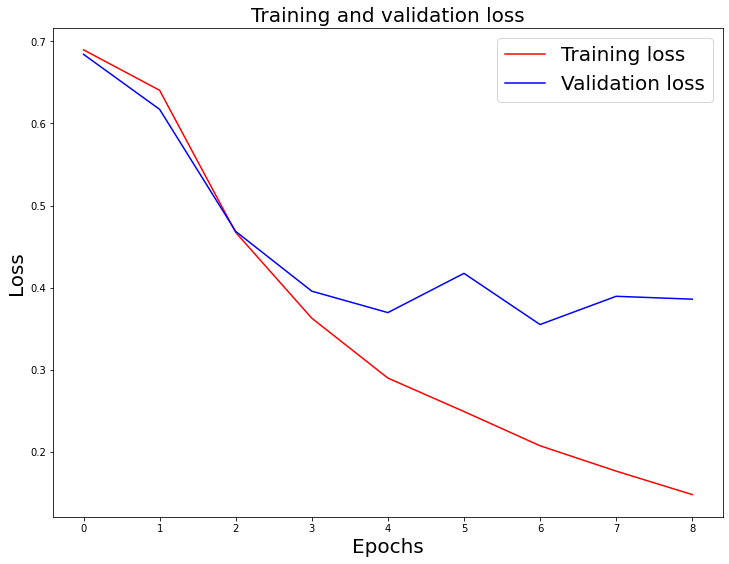

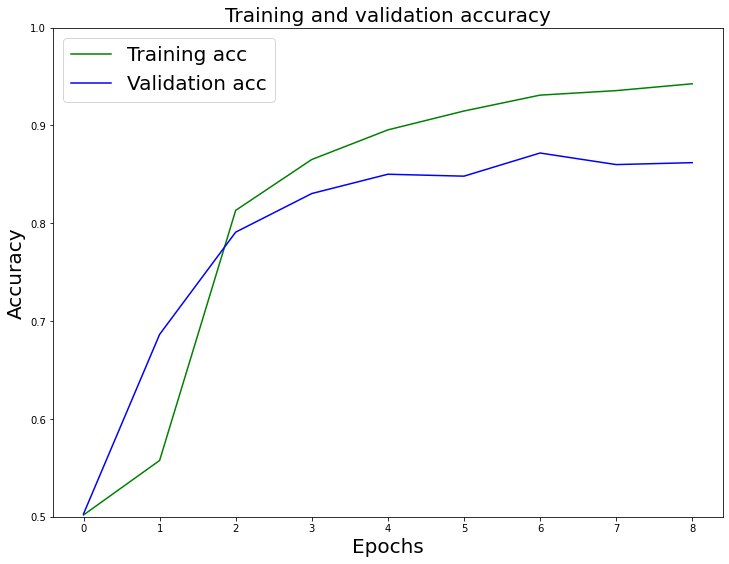

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()